In [ ]:
!pip install tensorflow

**Import necessary libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import drive

In [ ]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Define directories for training and testing data**

In [ ]:
# Data paths (update these paths to the correct locations on your Google Drive)
train_dir = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/train'
test_dir = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/test'

**Explore the data**

In [ ]:
import os

def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                count += 1
    return count

train_image_count = count_images(train_dir)
test_image_count = count_images(test_dir)

print(f'Number of images in training directory: {train_image_count}')
print(f'Number of images in test directory: {test_image_count}')


Number of images in training directory: 1303
Number of images in test directory: 194


In [ ]:
def get_image_shapes(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                print(f'Image path: {img_path}, Shape: {img_array.shape}')

# Directory paths (update with your actual paths)
train_dir = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/train'
test_dir = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/test'

print('Train Directory:')
get_image_shapes(train_dir)

print('\nTest Directory:')
get_image_shapes(test_dir)

Train Directory:
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/photo-1493106819501-66d381c466f1.jpeg, Shape: (5184, 3456, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/pm2.jpg, Shape: (3264, 2448, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/pm1.jpg, Shape: (3264, 2448, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/pm.jpg, Shape: (3264, 2448, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/pm3.jpg, Shape: (3264, 2448, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/12.jpg, Shape: (428, 320, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/119.jpg, Shape: (428, 320, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/train/without_mask/11707.jpg, Shape: (519, 350, 3)
Image path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/tr

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255, ## Normalize pixel values to [0, 1]
    rotation_range=10, # Rotate images by 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1, # Shift images vertically by 10% of the height
    shear_range=0.1,   # Shear intensity (angle in counter-clockwise direction)
    zoom_range=0.1,  # Zoom range [1-zoom_range, 1+zoom_range]
    horizontal_flip=True,  # Flip images horizontally
    validation_split=0.2 # Fraction of images reserved for validation (subset='training' only)
)

**Configure ImageDataGenerator for Test Data**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

**Generate Batches of Data Using flow_from_directory**

 **For Training Data**

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50), # Resize images to 50x50 pixels
    batch_size=32,  # Number of images in each batch
    class_mode='binary',  # Mode for yielding the targets (binary for binary classification)
    subset='training',  # Subset of data (training data)
    color_mode='grayscale'  # Subset of data (validation data)
)

Found 1053 images belonging to 2 classes.


**For Validation Data**

In [ ]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50), # Resize images to 50x50 pixels
    batch_size=32,   # Number of images in each batch
    class_mode='binary',  # Mode for yielding the targets (binary for binary classification)
    subset='validation', # Subset of data (validation data)
    color_mode='grayscale' # Subset of data (validation data)
)

Found 262 images belonging to 2 classes.


**For Test Data**

In [ ]:

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50), # Resize images to 50x50 pixels
    batch_size=32,  # Number of images in each batch
    class_mode='binary',  # Mode for yielding the targets (binary for binary classification)
    color_mode='grayscale' # Subset of data (validation data)
)

Found 194 images belonging to 2 classes.


**Build a custom CNN model**

In [ ]:
input_shape = (50, 50, 1)
inputs = Input(shape=input_shape)

**Convolutional layers**

In [ ]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

**Fully connected layers**

In [ ]:
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

**Create the model**

In [ ]:

model = Model(inputs=inputs, outputs=outputs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

**Train the Model**

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
33/33 [==============================] - 18s 500ms/step - loss: 0.6875 - accuracy: 0.5176 - val_loss: 0.6795 - val_accuracy: 0.5382
Epoch 2/50
33/33 [==============================] - 15s 450ms/step - loss: 0.6689 - accuracy: 0.5973 - val_loss: 0.6544 - val_accuracy: 0.6985
Epoch 3/50
33/33 [==============================] - 15s 441ms/step - loss: 0.6516 - accuracy: 0.6220 - val_loss: 0.6243 - val_accuracy: 0.6908
Epoch 4/50
33/33 [==============================] - 18s 537ms/step - loss: 0.6303 - accuracy: 0.6353 - val_loss: 0.6090 - val_accuracy: 0.6450
Epoch 5/50
33/33 [==============================] - 16s 481ms/step - loss: 0.6027 - accuracy: 0.6895 - val_loss: 0.5656 - val_accuracy: 0.7939
Epoch 6/50
33/33 [==============================] - 16s 472ms/step - loss: 0.5634 - accuracy: 0.7322 - val_loss: 0.5448 - val_accuracy: 0.7328
Epoch 7/50
33/33 [==============================] - 15s 463ms/step - loss: 0.5412 - accuracy: 0.7312 - val_loss: 0.5037 - val_accuracy: 0.7557

**Evaluate the Model on Test Data**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 [==============================] - 2s 204ms/step - loss: 0.1103 - accuracy: 0.9794
Test Accuracy: 97.94%


**Plot Training and Validation Metrics**

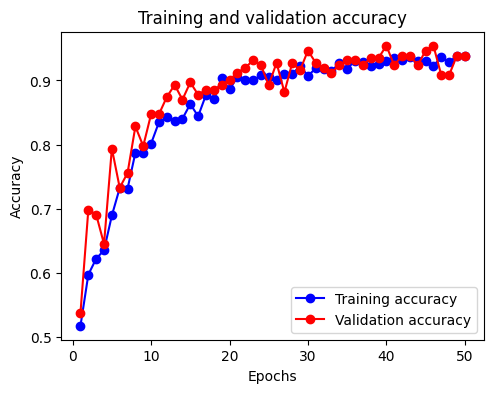

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

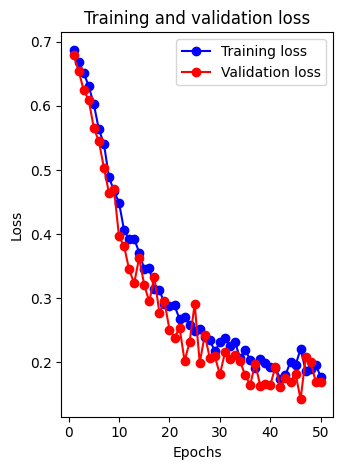

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**TESTING FOR RANDOM IMAGES**

**Function to Preprocess and Predict on a Single Image**

In [ ]:
def preprocess_image(img_path, target_size=(50, 50)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size, color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array


In [ ]:
def predict_mask(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0][0]
    class_label = 'WithMask' if prediction < 0.5 else 'WithoutMask'

    print(f'Image Path: {img_path}, Prediction: {prediction:.4f}, Class: {class_label}')

    plt.imshow(np.squeeze(img_array), cmap='gray')
    plt.title(f'Predicted: {class_label}')
    plt.axis('off')
    plt.show()

**Usage of predict_mask Function**

1/1 [==============================] - 0s 86ms/step
Image Path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/test/without_mask/10.jpg, Prediction: 0.9966, Class: WithoutMask


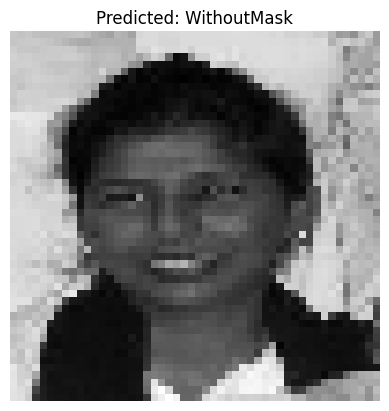

In [ ]:
image_path = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/test/without_mask/10.jpg'  # Update with your image path
predict_mask(image_path)

1/1 [==============================] - 0s 35ms/step
Image Path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/test/with_mask/167-with-mask.jpg, Prediction: 0.0472, Class: WithMask


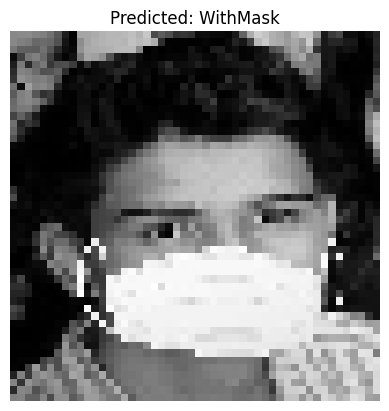

In [ ]:
image_path_1 = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/test/with_mask/167-with-mask.jpg'  # Update with your image path
predict_mask(image_path_1)

1/1 [==============================] - 0s 25ms/step
Image Path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/test/with_mask/306-with-mask.jpg, Prediction: 0.0170, Class: WithMask


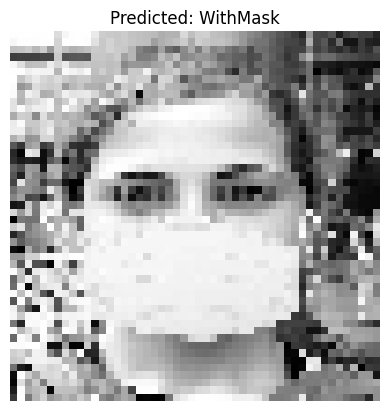

In [ ]:
image_path_2 = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/test/with_mask/306-with-mask.jpg'  # Update with your image path
predict_mask(image_path_2)

1/1 [==============================] - 0s 40ms/step
Image Path: /content/drive/MyDrive/GrayScale28X28MaskDataSet/test/WhatsApp Image 2024-06-18 at 5.50.28 PM.jpeg, Prediction: 0.9803, Class: WithoutMask


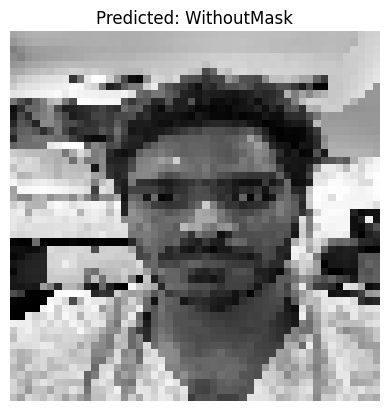

In [ ]:
My_Image = '/content/drive/MyDrive/GrayScale28X28MaskDataSet/test/WhatsApp Image 2024-06-18 at 5.50.28 PM.jpeg'  # Update with your image path
predict_mask(My_Image)

In [2]:
!pip install nbconvert

In [12]:
!jupyter nbconvert Mask_identification.ipynb --to html


[NbConvertApp] WARNING | pattern 'Mask_identification.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exe